# Procesamiento de dataset Student Depression

Creamos la sesion de spark conectandose con el contendeor master de nuesto docker Compose

In [1]:
from pyspark.sql import SparkSession

# Crear la sesi√≥n de Spark conect√°ndose al master de nuestro Docker Compose
spark = SparkSession.builder \
    .appName("StudentDepressionTraining") \
    .master("spark://spark-master:7077") \
    .config("spark.executor.memory", "1g") \
    .getOrCreate()

print("‚úÖ Sesi√≥n de Spark creada exitosamente!")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/17 02:45:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


‚úÖ Sesi√≥n de Spark creada exitosamente!


Carga del dataset desde hdfs

In [2]:
# Cargar el dataset de estudiantes directamente desde HDFS
file_path = "hdfs://namenode:8020/data/student_depression_dataset.csv"
print(f"Cargando datos desde: {file_path}")

Cargando datos desde: hdfs://namenode:8020/data/student_depression_dataset.csv


In [3]:

df_spark = spark.read.csv(
    file_path,
    header=True,      # Usa la primera fila como nombres de columna
    inferSchema=True  # Intenta adivinar los tipos de datos (int, double, etc.)
)

## Limpieza de los datos

In [4]:
import re
for column in df_spark.columns:
    # Quita espacios, ?, y otros caracteres problem√°ticos
    new_col_name = re.sub(r'[\s\?]', '', column) 
    df_spark = df_spark.withColumnRenamed(column, new_col_name)

print("--- Schema y muestra de los datos cargados correctamente ---")
df_spark.printSchema()
df_spark.show(5)

--- Schema y muestra de los datos cargados correctamente ---
root
 |-- id: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- City: string (nullable = true)
 |-- Profession: string (nullable = true)
 |-- AcademicPressure: double (nullable = true)
 |-- WorkPressure: double (nullable = true)
 |-- CGPA: double (nullable = true)
 |-- StudySatisfaction: double (nullable = true)
 |-- JobSatisfaction: double (nullable = true)
 |-- SleepDuration: string (nullable = true)
 |-- DietaryHabits: string (nullable = true)
 |-- Degree: string (nullable = true)
 |-- Haveyoueverhadsuicidalthoughts: string (nullable = true)
 |-- Work/StudyHours: double (nullable = true)
 |-- FinancialStress: string (nullable = true)
 |-- FamilyHistoryofMentalIllness: string (nullable = true)
 |-- Depression: integer (nullable = true)

+---+------+----+-------------+----------+----------------+------------+----+-----------------+---------------+-------------------+-----

## Analisis Exploratorio 

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

mkdir -p failed for path /.config/matplotlib: [Errno 13] Permission denied: '/.config'
Matplotlib created a temporary cache directory at /tmp/matplotlib-gz0truaj because there was an issue with the default path (/.config/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [6]:
print("--- Distribuci√≥n de la Variable Objetivo: Depression ---")
# Agrupar por la columna 'Depression' y contar
depression_counts = df_spark.groupBy("Depression").count().toPandas()

--- Distribuci√≥n de la Variable Objetivo: Depression ---


In [7]:
# Visualizar
sns.barplot(x='Depression', y='count', data=depression_counts)
plt.title('Distribuci√≥n de Estudiantes con y sin Depresi√≥n')
plt.show()


Como podemos observar hay mas personas deprimidas que no deprimidas, por lo cual nuestro grupo esta "sesgado"

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, isnan, when, count


In [9]:
print("--- Conteo de valores nulos o NaN por columna ---")
df_spark.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_spark.columns]).show()

--- Conteo de valores nulos o NaN por columna ---


[Stage 6:>                                                          (0 + 1) / 1]

+---+------+---+----+----------+----------------+------------+----+-----------------+---------------+-------------+-------------+------+------------------------------+---------------+---------------+----------------------------+----------+
| id|Gender|Age|City|Profession|AcademicPressure|WorkPressure|CGPA|StudySatisfaction|JobSatisfaction|SleepDuration|DietaryHabits|Degree|Haveyoueverhadsuicidalthoughts|Work/StudyHours|FinancialStress|FamilyHistoryofMentalIllness|Depression|
+---+------+---+----+----------+----------------+------------+----+-----------------+---------------+-------------+-------------+------+------------------------------+---------------+---------------+----------------------------+----------+
|  0|     0|  0|   0|         0|               0|           0|   0|                0|              0|            0|            0|     0|                             0|              0|              0|                           0|         0|
+---+------+---+----+----------+--------

Nuestro dataset esta limpio de valores nulos o NaN

### Descripcion de los datos

In [10]:
df_spark.describe(['Age', 'AcademicPressure', 'WorkPressure', 'CGPA', 'Work/StudyHours','Depression','id','StudySatisfaction','JobSatisfaction','FinancialStress']).show()


25/06/17 02:46:19 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
[Stage 9:>                                                          (0 + 1) / 1]

+-------+-----------------+------------------+--------------------+------------------+------------------+------------------+-----------------+-----------------+--------------------+------------------+
|summary|              Age|  AcademicPressure|        WorkPressure|              CGPA|   Work/StudyHours|        Depression|               id|StudySatisfaction|     JobSatisfaction|   FinancialStress|
+-------+-----------------+------------------+--------------------+------------------+------------------+------------------+-----------------+-----------------+--------------------+------------------+
|  count|            27901|             27901|               27901|             27901|             27901|             27901|            27901|            27901|               27901|             27901|
|   mean|25.82230027597577|3.1412135765743163|4.300921113938568...|7.6561041718936975| 7.156983620658758|0.5854987276441704| 70442.1494211677|2.943837138453819|6.809791763736067E-4|3.1398666571080

dada la informacion obtenemos que la mayoria de estudiantes no trabajan, el promedia de edad es de 25 a√±os siendo todos ellos mayores de edad , la mayoria se sienten medianamente presionados por la universidad, y de igual forma se sienten medianamente satisfechos con la universidad, la mayoria trabaja/estudia casi 8 horas ( una jornada laboral promedio), y uno de cada dos estudiantes se considera con depresion

## Visualizaci√≥n de Caracteristicas Clave vs Depresi√≥n

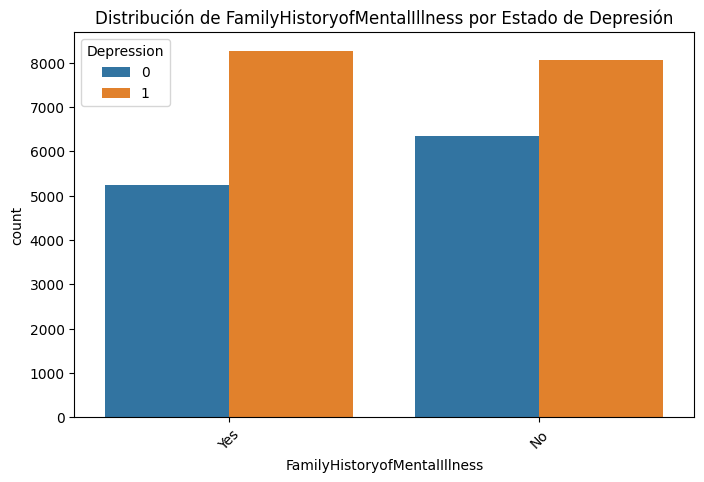

In [11]:
key_features = ['AcademicPressure', 'FinancialStress', 'FamilyHistoryofMentalIllness']
for feature in key_features:
    # Agrupamos en Spark y traemos el resultado peque√±o a Pandas para graficar
    plot_data = df_spark.groupBy(feature, "Depression").count().toPandas()
    
    plt.figure(figsize=(8, 5))
    sns.barplot(x=feature, y='count', hue='Depression', data=plot_data)
    plt.title(f'Distribuci√≥n de {feature} por Estado de Depresi√≥n')
    plt.xticks(rotation=45)
    plt.show()

# comenzamos con el pre-procesamiento 
vamos a codificar nuestras variables para ver la correlacion entre los datos 

In [12]:
# Celda 3 (Corregida)

from pyspark.sql.functions import col, when
from pyspark.sql.types import DoubleType, IntegerType

print("--- Pre-procesamiento de Datos con Spark (Versi√≥n Robusta) ---")

# --- Mapeo Manual de Columnas ---
df_processed = df_spark \
    .withColumn("Suicidal_Thoughts_num", when(col("Haveyoueverhadsuicidalthoughts") == "Yes", 1).otherwise(0)) \
    .withColumn("Family_History_num", when(col("FamilyHistoryofMentalIllness") == "Yes", 1).otherwise(0)) \
    .withColumn("Gender_num", when(col("Gender") == "Male", 1).otherwise(0)) \
    .withColumn("Dietary_Habits_num", 
        when(col("DietaryHabits") == "Healthy", 2)
        .when(col("DietaryHabits") == "Moderate", 1)
        .otherwise(0)) \
    .withColumn("Sleep_Duration_num", 
        when(col("SleepDuration").contains("More than 8"), 3)
        .when(col("SleepDuration").contains("7-8"), 2)
        .when(col("SleepDuration").contains("5-6"), 1)
        .otherwise(0))

# --- Omitir columnas originales y de alta cardinalidad ---
cols_to_drop = [
    'id', 'City', 'Profession', 'Degree', 'Gender', 'Haveyoueverhadsuicidalthoughts', 
    'FamilyHistoryofMentalIllness', 'DietaryHabits', 'SleepDuration'
]
df_numeric_base = df_processed.drop(*cols_to_drop)


# Nos aseguramos de que todas las columnas que vamos a usar sean num√©ricas.
# Usamos .cast() para convertir expl√≠citamente.
df_numeric = df_numeric_base \
    .withColumn("Age", col("Age").cast(IntegerType())) \
    .withColumn("AcademicPressure", col("AcademicPressure").cast(DoubleType())) \
    .withColumn("WorkPressure", col("WorkPressure").cast(DoubleType())) \
    .withColumn("CGPA", col("CGPA").cast(DoubleType())) \
    .withColumn("StudySatisfaction", col("StudySatisfaction").cast(DoubleType())) \
    .withColumn("JobSatisfaction", col("JobSatisfaction").cast(DoubleType())) \
    .withColumn("FinancialStress", col("FinancialStress").cast(DoubleType())) \
    .withColumn("Depression", col("Depression").cast(IntegerType())) \
    .withColumnRenamed("Work/StudyHours", "WorkStudyHours") # Renombramos para quitar la '/'

# Volvemos a castear la columna renombrada
df_numeric = df_numeric.withColumn("WorkStudyHours", col("WorkStudyHours").cast(DoubleType()))

# Renombrar la columna objetivo a 'label'
df_numeric = df_numeric.withColumnRenamed("Depression", "label")

# Eliminar filas con nulos que se puedan haber generado durante el casting
df_numeric = df_numeric.dropna()

print("--- DataFrame completamente num√©rico y limpio ---")
df_numeric.printSchema()

--- Pre-procesamiento de Datos con Spark (Versi√≥n Robusta) ---
--- DataFrame completamente num√©rico y limpio ---
root
 |-- Age: integer (nullable = true)
 |-- AcademicPressure: double (nullable = true)
 |-- WorkPressure: double (nullable = true)
 |-- CGPA: double (nullable = true)
 |-- StudySatisfaction: double (nullable = true)
 |-- JobSatisfaction: double (nullable = true)
 |-- WorkStudyHours: double (nullable = true)
 |-- FinancialStress: double (nullable = true)
 |-- label: integer (nullable = true)
 |-- Suicidal_Thoughts_num: integer (nullable = false)
 |-- Family_History_num: integer (nullable = false)
 |-- Gender_num: integer (nullable = false)
 |-- Dietary_Habits_num: integer (nullable = false)
 |-- Sleep_Duration_num: integer (nullable = false)



## Correlaci√≥n de variables

In [13]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd

# Para calcular la correlaci√≥n, primero debemos poner todas las caracter√≠sticas en un vector
numeric_cols = df_numeric.drop("label").columns
assembler_corr = VectorAssembler(inputCols=numeric_cols, outputCol="corr_features")
df_vector_corr = assembler_corr.transform(df_numeric).select("corr_features", "label")

# Calcular la matriz de correlaci√≥n de Pearson
matrix = Correlation.corr(df_vector_corr, "corr_features").collect()[0][0]
corr_matrix_pd = pd.DataFrame(matrix.toArray(), columns=numeric_cols, index=numeric_cols)

# Visualizar el heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix_pd, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlaci√≥n', fontsize=18)
plt.show()

# --- Selecci√≥n de Caracter√≠sticas basada en la Correlaci√≥n ---
correlations = []
for col_name in numeric_cols:
    corr_value = df_numeric.stat.corr("label", col_name)
    correlations.append((col_name, corr_value))

corr_df = pd.DataFrame(correlations, columns=['feature', 'correlation']).sort_values(by='correlation', key=abs, ascending=False)
print("\nüîç Correlaciones con 'Depression':")
print(corr_df)

umbral_correlacion = 0.05
caracteristicas_relevantes = corr_df[abs(corr_df['correlation']) > umbral_correlacion]['feature'].tolist()
print(f"\n‚úÖ Caracter√≠sticas seleccionadas: {caracteristicas_relevantes}")


üîç Correlaciones con 'Depression':
                  feature  correlation
8   Suicidal_Thoughts_num     0.546290
1        AcademicPressure     0.474793
7         FinancialStress     0.363591
0                     Age    -0.226511
6          WorkStudyHours     0.208627
11     Dietary_Habits_num    -0.206734
4       StudySatisfaction    -0.168010
12     Sleep_Duration_num    -0.086938
9      Family_History_num     0.053554
3                    CGPA     0.022268
5         JobSatisfaction    -0.003483
2            WorkPressure    -0.003351
10             Gender_num     0.001819

‚úÖ Caracter√≠sticas seleccionadas: ['Suicidal_Thoughts_num', 'AcademicPressure', 'FinancialStress', 'Age', 'WorkStudyHours', 'Dietary_Habits_num', 'StudySatisfaction', 'Sleep_Duration_num', 'Family_History_num']


In [14]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline

print("--- Construyendo el Pipeline de Spark ML con las caracter√≠sticas seleccionadas ---")

# --- Etapa 1: Ensamblador de Vectores ---
# Usamos S√ìLO la lista 'caracteristicas_relevantes' que acabas de generar.
final_assembler = VectorAssembler(inputCols=caracteristicas_relevantes, outputCol="assembled_features")

# --- Etapa 2: Escalador ---
# Escala el vector de caracter√≠sticas para que todos los valores est√©n entre 0 y 1.
scaler = MinMaxScaler(inputCol="assembled_features", outputCol="features") # La salida que usar√° el modelo se llamar√° "features"

# --- Dividir los datos en entrenamiento y prueba ---
# Usamos el DataFrame df_numeric que ya tiene todos los datos pre-procesados y limpios.
(train_data, test_data) = df_numeric.randomSplit([0.8, 0.2], seed=42)

print(f"\nDatos divididos: ~{train_data.count()} para entrenamiento, ~{test_data.count()} para prueba.")
print("‚úÖ Pipeline de pre-procesamiento definido. ¬°Listo para a√±adir un modelo!")

--- Construyendo el Pipeline de Spark ML con las caracter√≠sticas seleccionadas ---

Datos divididos: ~22352 para entrenamiento, ~5546 para prueba.
‚úÖ Pipeline de pre-procesamiento definido. ¬°Listo para a√±adir un modelo!


In [18]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# --- 1. Definir los modelos de Spark ML que vamos a probar ---
lr_spark = LogisticRegression(featuresCol="features", labelCol="label")
rf_spark = RandomForestClassifier(featuresCol="features", labelCol="label", seed=42)

modelos_spark = {
    "Regresi√≥n Log√≠stica Spark": lr_spark,
    "Random Forest Spark": rf_spark
}

# --- 2. Entrenar y evaluar cada modelo ---
best_model_pipeline = None
best_accuracy = 0.0
best_model_name = ""

for nombre, modelo in modelos_spark.items():
    print(f"--- Entrenando: {nombre} ---")
    
    # a. Crear el Pipeline completo a√±adiendo el modelo al final
    pipeline = Pipeline(stages=[final_assembler, scaler, modelo])
    
    # b. Entrenar el Pipeline completo. Spark ejecuta todas las etapas en orden.
    pipeline_model = pipeline.fit(train_data)
    
    # c. Realizar predicciones en el conjunto de prueba
    predictions = pipeline_model.transform(test_data)
    
    # d. Evaluar el rendimiento
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    
    print(f"Precisi√≥n (Accuracy) de {nombre}: {accuracy:.4f}")
    
    # Tambi√©n podemos ver el F1-score
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    f1_score = evaluator_f1.evaluate(predictions)
    print(f"Puntuaci√≥n F1 de {nombre}: {f1_score:.4f}")
    print("-" * 50)
    
    # Guardamos el pipeline del mejor modelo basado en accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_pipeline = pipeline_model
        best_model_name = nombre

print(f"\nüèÜ El mejor modelo es: '{best_model_name}' con una precisi√≥n de {best_accuracy:.4f}")

#

--- Entrenando: Regresi√≥n Log√≠stica Spark ---
Precisi√≥n (Accuracy) de Regresi√≥n Log√≠stica Spark: 0.8525
Puntuaci√≥n F1 de Regresi√≥n Log√≠stica Spark: 0.8520
--------------------------------------------------
--- Entrenando: Random Forest Spark ---
Precisi√≥n (Accuracy) de Random Forest Spark: 0.8303
Puntuaci√≥n F1 de Random Forest Spark: 0.8296
--------------------------------------------------

üèÜ El mejor modelo es: 'Regresi√≥n Log√≠stica Spark' con una precisi√≥n de 0.8525


In [ ]:
output_path = "hdfs://namenode:8020/models/spark_student_depression_model"

print(f"\nGuardando el mejor modelo ('{best_model_name}') en HDFS: {output_path}")

# El comando .save() sabe c√≥mo escribir en HDFS si la ruta empieza con 'hdfs://'
if best_model_pipeline:
    # Primero creamos el directorio padre en HDFS por si no existe
    # (Necesitamos importar hdfs3 o usar comandos de shell, pero Spark deber√≠a poder crearlo)
    # Sin embargo, una forma m√°s segura es asegurarnos de que /models exista
    # (Lo haremos desde la terminal si falla)
    best_model_pipeline.write().overwrite().save(output_path)
    print(f"‚úÖ Modelo guardado exitosamente en HDFS.")
else:
    print("‚ùå No se guard√≥ ning√∫n modelo.")

# ... (El resto del c√≥digo, incluyendo spark.stop()) ...